In [1]:
import mxnet as mx
from mxnet import image, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.dpi']= 150

ctx = mx.gpu()

In [2]:
def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32')/255 - rgb_mean) / rgb_std
    return img.transpose((2,0,1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1,2,0))*rgb_std + rgb_mean).clip(0,1)

def extract_features(x, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        x = net[i](x)
        if i in style_layers:
            styles.append(x)
        if i in content_layers:
            contents.append(x)
    return contents, styles

def get_net(pretrained_net, content_layers, style_layers):
    net = nn.Sequential()
    for i in range(max(content_layers+style_layers)+1):
        net.add(pretrained_net.features[i])
    return net

def content_loss(yhat, y):
    return (yhat-y).square().mean()

def gram(x):
    c = x.shape[1]
    n = x.size / x.shape[1]
    y = x.reshape((c, int(n)))
    return nd.dot(y, y.T) / n

def style_loss(yhat, gram_y):
    return (gram(yhat) - gram_y).square().mean()

def tv_loss(yhat):
    return 0.5*((yhat[:,:,1:,:] - yhat[:,:,:-1,:]).abs().mean()+(yhat[:,:,:,1:] - yhat[:,:,:,:-1]).abs().mean())

def sum_loss(loss, preds, truths, weights):
    return nd.add_n(*[w*loss(yhat, y) for w, yhat, y in zip(weights, preds, truths)])

def get_contents(image_shape):
    content_x = preprocess(content_img, image_shape).copyto(ctx)
    content_y, _ = extract_features(content_x, content_layers, style_layers)
    return content_x, content_y

def get_styles(image_shape):
    style_x = preprocess(style_img, image_shape).copyto(ctx)
    _, style_y = extract_features(style_x, content_layers, style_layers)
    style_y = [gram(y) for y in style_y]
    return style_x, style_y

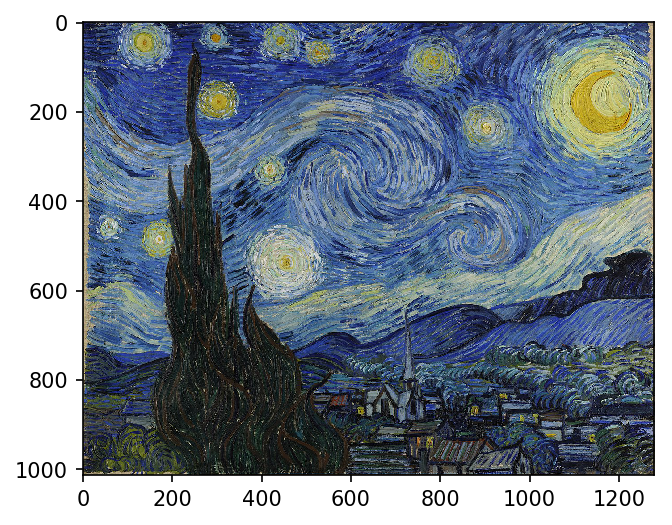

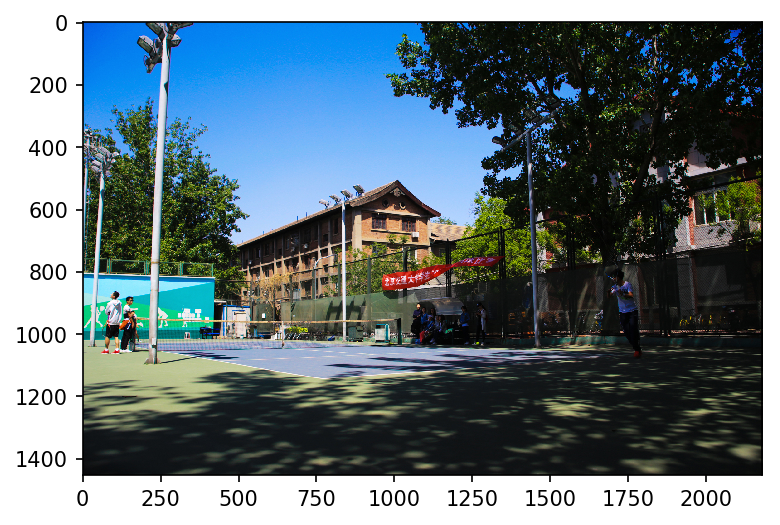

In [3]:
style_img = image.imread('style1.jpg')
content_img = image.imread('content.jpg')

plt.imshow(style_img.asnumpy())
plt.show()
plt.imshow(content_img.asnumpy())
plt.show()

In [4]:
pretrained_net = models.vgg19(pretrained=True)
style_layers = [0,5,10,19,28]
content_layers = [25]
net = get_net(pretrained_net, content_layers, style_layers)

rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

channels = [net[l].weight.shape[0] for l in style_layers]
style_weights = [1e4/n**2 for n in channels]
content_weights = [1]
tv_weight = 10

In [5]:
a = len(content_img[0])
image_shape = (1440, int(len(content_img)*(1440/len(content_img[0]))))

net.collect_params().reset_ctx(ctx)

content_x, content_y = get_contents(image_shape)
style_x, style_y = get_styles(image_shape)

x = content_x.copyto(ctx)
x.attach_grad()

In [6]:
lr = 0.1
epochs = 300

start = time()
for i in range(epochs):
    with autograd.record():
        content_py, style_py = extract_features(x, content_layers, style_layers)
        content_l  = sum_loss(content_loss, content_py, content_y, content_weights)
        style_l = sum_loss(style_loss, style_py, style_y, style_weights)
        tv_l = tv_weight * tv_loss(x)
        loss = style_l + content_l + tv_l
    loss.backward()
    x.grad[:] /= x.grad.abs().mean()+1e-8
    x[:] -= lr * x.grad
    nd.waitall()
    if i % 20 == 0:
        print('E %d, content %.2f, style %.2f, TV %.2f, T %.2f' % (
            i,content_l.asscalar(),style_l.asscalar(), tv_l.asscalar(), time()-start))
        start = time()
    if i in [40, 160, 240]:
        lr = lr * 0.1

E 0, content 0.00, style 165.31, TV 1.31, T 1.31
E 20, content 20.80, style 143.10, TV 2.90, T 18.54
E 40, content 21.11, style 193.42, TV 3.06, T 18.56
E 60, content 8.84, style 16.34, TV 2.85, T 18.90
E 80, content 7.06, style 12.14, TV 2.78, T 18.91
E 100, content 6.27, style 9.44, TV 2.72, T 18.68
E 120, content 5.86, style 7.65, TV 2.67, T 18.70
E 140, content 5.19, style 6.90, TV 2.62, T 18.81
E 160, content 4.92, style 6.13, TV 2.59, T 19.41
E 180, content 4.16, style 3.74, TV 2.55, T 17.48
E 200, content 3.95, style 3.49, TV 2.53, T 18.99
E 220, content 3.80, style 3.30, TV 2.50, T 19.05
E 240, content 3.68, style 3.15, TV 2.49, T 18.90
E 260, content 3.64, style 3.06, TV 2.48, T 18.83
E 280, content 3.60, style 3.01, TV 2.47, T 18.85


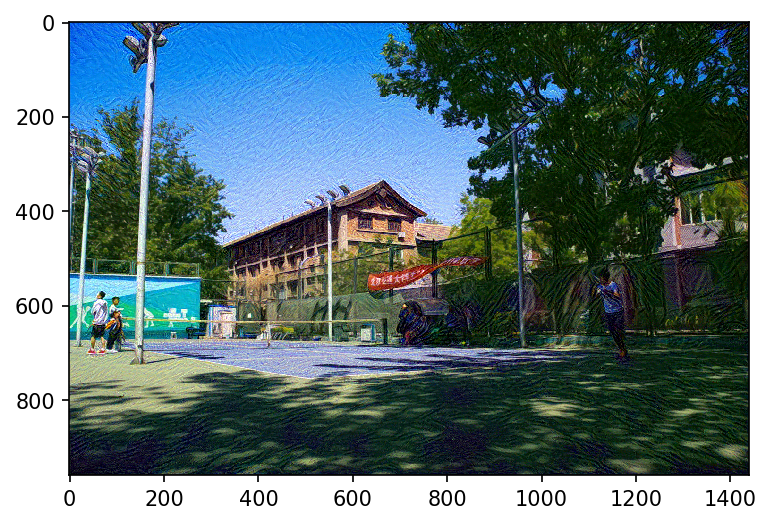

In [7]:
out = postprocess(x).asnumpy()
plt.imshow(out)
plt.show()
plt.imsave('out.png', out)